(8, 2)


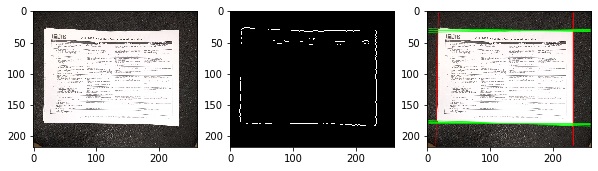

197 96900


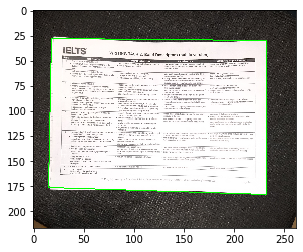

In [28]:
#https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/

import cv2
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
import itertools
%matplotlib inline 

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

filename = 'dataset/horizontal_curved_over_black.jpg'
image = cv2.imread(filename)


# Scale down to make operations faster
perc = 10
resized = cv2.resize(image, (image.shape[1]*perc//100, image.shape[0]*perc//100))
axes[0].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))

# Edges
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
edges = cv2.Canny(gray, threshold1=400, threshold2=410)

axes[1].imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))

# Hough lines
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([theta for rho, theta in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""
    intersections = []
    for l1 in lines[0]:
        for l2 in lines[1]:
            intersections.append(intersection(l1, l2)) 

    return intersections

lines = cv2.HoughLines(edges, 1, np.pi/180.0, 80)
if lines is None:
    print("No lines detected")
lines = lines.squeeze(axis=1)
print(lines.shape)
segmented_lines = segment_by_angle_kmeans(lines)
im_lines = resized.copy()

color = [(0,0,255),(0,255,0)]
for i, lines in enumerate(segmented_lines):
    for rho, theta in lines:
        x = np.cos(theta)
        y = np.sin(theta)
        x0, y0 = x*rho, y*rho
        pt1 = ( int(x0+1000*(-y)), int(y0+1000*(x)) )
        pt2 = ( int(x0-1000*(-y)), int(y0-1000*(x)) )
        cv2.line(im_lines, pt1, pt2, color[i], 1, cv2.LINE_AA)

axes[2].imshow(cv2.cvtColor(im_lines, cv2.COLOR_BGR2RGB))
plt.show()

intersec = np.array(segmented_intersections(segmented_lines), dtype=np.int32).squeeze(axis=1)
comb = list(itertools.combinations(intersec, 4)) # too complex

scores = []
for vertex in comb:
    polys = np.zeros(edges.shape, dtype=np.int32)
    cv2.polylines(polys, [np.array(vertex)], True, 255)
    mask = polys[edges > 0]
    scores.append(np.sum(mask))

best = np.argmax(scores)
print(best, scores[best])
cv2.polylines(resized, [np.array(comb[best])], True, (0,255,0))
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()